In [49]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import utils

In [50]:
learning_rate_anr_capex = 0
learning_rate_h2_capex = 0
results_path = './results/raw_results_anr_lr_'+str(learning_rate_anr_capex)+'_h2_lr_'+str(learning_rate_h2_capex)+'_wacc_'+str(utils.WACC)+'.xlsx'
clean_save_path = './results/clean_results_anr_lr_'+str(learning_rate_anr_capex)+'_h2_lr_'+str(learning_rate_h2_capex)+'_wacc_'+str(utils.WACC)+'.xlsx'
save_fig_path = './results/steel_anr_lr_'+str(learning_rate_anr_capex)+'_h2_lr_'+str(learning_rate_h2_capex)+'_wacc_'+str(utils.WACC)+'.png'

In [51]:
df = pd.read_excel(results_path, sheet_name='steel')
df.sort_values(by=['Breakeven price ($/MMBtu)'], inplace=True)
df.reset_index(inplace=True)
df.drop(columns=['index'], inplace=True)


In [52]:
anr_param = pd.read_excel('ANRs.xlsx', sheet_name='FOAK')

### Compute deployed power at each steel plant and cumulative deployed ANR capacity

In [53]:
anr_thermal_power = anr_param[['Power in MWt', 'Reactor']]
anr_thermal_power
df = df.merge(anr_thermal_power, how='inner', left_on=['ANR type'], right_on=['Reactor'])
df.sort_values(by=['Breakeven price ($/MMBtu)'], inplace=True)
df['Deployed Power (MWt)'] = df['Power in MWt']*df['# ANR modules']
df['ANR Nameplate Capacity (GWt)'] = df['Deployed Power (MWt)'].cumsum()/1000
df

,id,state,Steel prod. (ton/year),H2 Dem. (kg/day),Aux Elec Dem. (MWe),Net Revenues ($/year),Alkaline,HTSE,PEM,Ann. CO2 emissions (kgCO2eq/year),...,Conversion costs ($/year),ANR CRF,Depl. ANR Cap. (MWe),ANR type,# ANR modules,Breakeven price ($/MMBtu),Power in MWt,Reactor,Deployed Power (MWt),ANR Nameplate Capacity (GWt)
0,Cleveland-Cliffs Indiana Harbor steel plant,IN,5236000,1.033714e+06,341.347061,-1.710215e+09,0,1034,0,3.064169e+08,...,1.564082e+08,0.086325,1269,iMSR,9,1.348786,300,iMSR,2700,2.7
1,Cleveland-Cliffs Cleveland steel plant,OH,2810000,5.547627e+05,183.190459,-9.282037e+08,0,555,0,1.644524e+08,...,8.393948e+07,0.086325,705,iMSR,5,1.541180,300,iMSR,1500,4.2
2,U.S. Steel Gary Works,IN,6622000,1.307345e+06,431.703636,-2.200650e+09,0,1308,0,3.875548e+08,...,1.978104e+08,0.086325,1692,iMSR,12,1.645437,300,iMSR,3600,7.8
3,Cleveland-Cliffs Middletown steel plant,OH,2090000,4.126171e+05,136.251978,-7.075529e+08,0,413,0,1.223345e+08,...,6.243185e+07,0.086325,564,iMSR,4,1.969169,300,iMSR,1200,9.0
8,Cleveland-Cliffs Riverdale steel plant,IL,1000000,1.974245e+05,65.192334,-3.387017e+08,0,198,0,5.789983e+07,...,2.987170e+07,0.086325,240,PBR-HTGR,3,1.977480,200,PBR-HTGR,600,9.6
4,U.S. Steel Edgar Thomson Plant,PA,2078000,4.102480e+05,135.469670,-7.049254e+08,0,411,0,1.216669e+08,...,6.207339e+07,0.086325,564,iMSR,4,2.005123,300,iMSR,1200,10.8
5,Cleveland-Cliffs Burns Harbor steel plant,IN,3635000,7.176379e+05,236.974134,-1.233202e+09,0,718,0,2.127398e+08,...,1.085836e+08,0.086325,987,iMSR,7,2.006434,300,iMSR,2100,12.9
6,U.S. Steel Granite City Works,IL,2540000,5.014581e+05,165.588528,-8.683741e+08,0,502,0,1.486816e+08,...,7.587412e+07,0.086325,705,iMSR,5,2.142934,300,iMSR,1500,14.4
7,Cleveland-Cliffs Dearborn steel plant,MI,2500000,4.935612e+05,162.980835,-8.594973e+08,0,494,0,1.463313e+08,...,7.467925e+07,0.086325,705,iMSR,5,2.242863,300,iMSR,1500,15.9


### Compute cumulative number of viable steel plants and ANR modules

In [54]:
df['Viable ANR modules count'] = df['# ANR modules'].cumsum()
df.reset_index(inplace=True)
df.drop(columns=['index'], inplace=True)
df['Viable ANR steel plants count'] = df.index+1
df.head(5)

,id,state,Steel prod. (ton/year),H2 Dem. (kg/day),Aux Elec Dem. (MWe),Net Revenues ($/year),Alkaline,HTSE,PEM,Ann. CO2 emissions (kgCO2eq/year),...,Depl. ANR Cap. (MWe),ANR type,# ANR modules,Breakeven price ($/MMBtu),Power in MWt,Reactor,Deployed Power (MWt),ANR Nameplate Capacity (GWt),Viable ANR modules count,Viable ANR steel plants count
0,Cleveland-Cliffs Indiana Harbor steel plant,IN,5236000,1.033714e+06,341.347061,-1.710215e+09,0,1034,0,3.064169e+08,...,1269,iMSR,9,1.348786,300,iMSR,2700,2.7,9,1
1,Cleveland-Cliffs Cleveland steel plant,OH,2810000,5.547627e+05,183.190459,-9.282037e+08,0,555,0,1.644524e+08,...,705,iMSR,5,1.541180,300,iMSR,1500,4.2,14,2
2,U.S. Steel Gary Works,IN,6622000,1.307345e+06,431.703636,-2.200650e+09,0,1308,0,3.875548e+08,...,1692,iMSR,12,1.645437,300,iMSR,3600,7.8,26,3
3,Cleveland-Cliffs Middletown steel plant,OH,2090000,4.126171e+05,136.251978,-7.075529e+08,0,413,0,1.223345e+08,...,564,iMSR,4,1.969169,300,iMSR,1200,9.0,30,4
4,Cleveland-Cliffs Riverdale steel plant,IL,1000000,1.974245e+05,65.192334,-3.387017e+08,0,198,0,5.789983e+07,...,240,PBR-HTGR,3,1.977480,200,PBR-HTGR,600,9.6,33,5


### Compute avoided carbon emissions 

In [55]:
demand_steel_df = pd.read_excel('./h2_demand_bfbof_steel_us_2022.xlsx', sheet_name='processed')
df = df.merge(demand_steel_df, left_on='id', right_on='Plant')
df

,id,state,Steel prod. (ton/year),H2 Dem. (kg/day),Aux Elec Dem. (MWe),Net Revenues ($/year),Alkaline,HTSE,PEM,Ann. CO2 emissions (kgCO2eq/year),...,CITY NAME,COUNTY NAME,ZIP CODE,STATE,Status,Main production process,GHG QUANTITY (METRIC TONS CO2e),Steel production capacity (ttpa),Hydrogen demand (kg/day),Electricity demand (MWe)
0,Cleveland-Cliffs Indiana Harbor steel plant,IN,5236000,1.033714e+06,341.347061,-1.710215e+09,0,1034,0,3.064169e+08,...,EAST CHICAGO,Lake,46312,IN,operating,integrated (BF),5434569,5236,1.033714e+06,341.347061
1,Cleveland-Cliffs Cleveland steel plant,OH,2810000,5.547627e+05,183.190459,-9.282037e+08,0,555,0,1.644524e+08,...,CLEVELAND,Cuyahoga,44105,OH,operating,integrated (BF),2942469,2810,5.547627e+05,183.190459
2,U.S. Steel Gary Works,IN,6622000,1.307345e+06,431.703636,-2.200650e+09,0,1308,0,3.875548e+08,...,GARY,Lake,46402,IN,operating,integrated (BF),10300727,6622,1.307345e+06,431.703636
3,Cleveland-Cliffs Middletown steel plant,OH,2090000,4.126171e+05,136.251978,-7.075529e+08,0,413,0,1.223345e+08,...,MIDDLETOWN,Butler,45043,OH,operating,integrated (BF),3227354,2090,4.126171e+05,136.251978
4,Cleveland-Cliffs Riverdale steel plant,IL,1000000,1.974245e+05,65.192334,-3.387017e+08,0,198,0,5.789983e+07,...,RIVERDALE,COOK COUNTY,60827,IL,operating,oxygen,134985,1000,1.974245e+05,65.192334
5,U.S. Steel Edgar Thomson Plant,PA,2078000,4.102480e+05,135.469670,-7.049254e+08,0,411,0,1.216669e+08,...,Braddock,Allegheny,15104,PA,operating,integrated (BF),2995635,2078,4.102480e+05,135.469670
6,Cleveland-Cliffs Burns Harbor steel plant,IN,3635000,7.176379e+05,236.974134,-1.233202e+09,0,718,0,2.127398e+08,...,BURNS HARBOR,PORTER COUNTY,46304,IN,operating,integrated (BF),6839238,3635,7.176379e+05,236.974134
7,U.S. Steel Granite City Works,IL,2540000,5.014581e+05,165.588528,-8.683741e+08,0,502,0,1.486816e+08,...,GRANITE CITY,MADISON COUNTY,62040,IL,operating,integrated (BF),1932947,2540,5.014581e+05,165.588528
8,Cleveland-Cliffs Dearborn steel plant,MI,2500000,4.935612e+05,162.980835,-8.594973e+08,0,494,0,1.463313e+08,...,DEARBORN,WAYNE COUNTY,48120,MI,operating,integrated (BF),1015576,2500,4.935612e+05,162.980835


In [56]:
df['Ann. avoided CO2 emissions (MMT-CO2/year)'] = (df['GHG QUANTITY (METRIC TONS CO2e)'] - (df['Ann. CO2 emissions (kgCO2eq/year)']/1e3))/1e6
df['Viable avoided emissions (MMT-CO2/year)'] = df['Ann. avoided CO2 emissions (MMT-CO2/year)'].cumsum()
df

,id,state,Steel prod. (ton/year),H2 Dem. (kg/day),Aux Elec Dem. (MWe),Net Revenues ($/year),Alkaline,HTSE,PEM,Ann. CO2 emissions (kgCO2eq/year),...,ZIP CODE,STATE,Status,Main production process,GHG QUANTITY (METRIC TONS CO2e),Steel production capacity (ttpa),Hydrogen demand (kg/day),Electricity demand (MWe),Ann. avoided CO2 emissions (MMT-CO2/year),Viable avoided emissions (MMT-CO2/year)
0,Cleveland-Cliffs Indiana Harbor steel plant,IN,5236000,1.033714e+06,341.347061,-1.710215e+09,0,1034,0,3.064169e+08,...,46312,IN,operating,integrated (BF),5434569,5236,1.033714e+06,341.347061,5.128152,5.128152
1,Cleveland-Cliffs Cleveland steel plant,OH,2810000,5.547627e+05,183.190459,-9.282037e+08,0,555,0,1.644524e+08,...,44105,OH,operating,integrated (BF),2942469,2810,5.547627e+05,183.190459,2.778017,7.906169
2,U.S. Steel Gary Works,IN,6622000,1.307345e+06,431.703636,-2.200650e+09,0,1308,0,3.875548e+08,...,46402,IN,operating,integrated (BF),10300727,6622,1.307345e+06,431.703636,9.913172,17.819341
3,Cleveland-Cliffs Middletown steel plant,OH,2090000,4.126171e+05,136.251978,-7.075529e+08,0,413,0,1.223345e+08,...,45043,OH,operating,integrated (BF),3227354,2090,4.126171e+05,136.251978,3.105020,20.924361
4,Cleveland-Cliffs Riverdale steel plant,IL,1000000,1.974245e+05,65.192334,-3.387017e+08,0,198,0,5.789983e+07,...,60827,IL,operating,oxygen,134985,1000,1.974245e+05,65.192334,0.077085,21.001446
5,U.S. Steel Edgar Thomson Plant,PA,2078000,4.102480e+05,135.469670,-7.049254e+08,0,411,0,1.216669e+08,...,15104,PA,operating,integrated (BF),2995635,2078,4.102480e+05,135.469670,2.873968,23.875414
6,Cleveland-Cliffs Burns Harbor steel plant,IN,3635000,7.176379e+05,236.974134,-1.233202e+09,0,718,0,2.127398e+08,...,46304,IN,operating,integrated (BF),6839238,3635,7.176379e+05,236.974134,6.626498,30.501912
7,U.S. Steel Granite City Works,IL,2540000,5.014581e+05,165.588528,-8.683741e+08,0,502,0,1.486816e+08,...,62040,IL,operating,integrated (BF),1932947,2540,5.014581e+05,165.588528,1.784265,32.286177
8,Cleveland-Cliffs Dearborn steel plant,MI,2500000,4.935612e+05,162.980835,-8.594973e+08,0,494,0,1.463313e+08,...,48120,MI,operating,integrated (BF),1015576,2500,4.935612e+05,162.980835,0.869245,33.155422


### Save clean version of results


In [57]:
df_clean = df[["id", 'state', 'Steel production capacity (ttpa)', 'H2 Dem. (kg/day)', 'HTSE', 'ANR type', '# ANR modules', 'Net Revenues ($/year)', 'Ann. avoided CO2 emissions (MMT-CO2/year)', 'Breakeven price ($/MMBtu)', 'Viable avoided emissions (MMT-CO2/year)']]

df_clean['H2 Dem. (kg/day)'] /=1e3
df_clean['HTSE'] = df_clean['HTSE'].apply(lambda x: int(x))
df_clean['H2 Dem. (kg/day)'] = df_clean['H2 Dem. (kg/day)'].apply(lambda x:np.round(x,1))
df_clean['Net Revenues ($/year)'] = df_clean['Net Revenues ($/year)'].apply(lambda x: np.round(x/1e6,1))
df_clean['Ann. avoided CO2 emissions (MMT-CO2/year)']= df_clean['Ann. avoided CO2 emissions (MMT-CO2/year)'].apply(lambda x: np.round(x,1))
df_clean['Avoided cost of CO2 ($/ton)'] = df_clean['Net Revenues ($/year)']/df_clean['Ann. avoided CO2 emissions (MMT-CO2/year)']
df_clean['Avoided cost of CO2 ($/ton)'] = df_clean['Avoided cost of CO2 ($/ton)'].apply(lambda x:np.round(np.abs(x),1))
df_clean['Breakeven price ($/MMBtu)'] = df_clean['Breakeven price ($/MMBtu)'].apply(lambda x : np.round(x,1))
df_clean.rename(columns={'H2 Dem (kg/day)': 'Demand (MT H2/day)', 
                         'ANR type': 'ANR', 
                         '# ANR modules': '#'}, inplace=True)


C:\Users\mgarrou\AppData\Local\Temp\ipykernel_10800\969032792.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['H2 Dem. (kg/day)'] /=1e3
C:\Users\mgarrou\AppData\Local\Temp\ipykernel_10800\969032792.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['HTSE'] = df_clean['HTSE'].apply(lambda x: int(x))
C:\Users\mgarrou\AppData\Local\Temp\ipykernel_10800\969032792.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,co

In [58]:

sheet_name = 'steel'
excel_file = clean_save_path
try:
# Load the existing Excel file
  with pd.ExcelFile(excel_file, engine='openpyxl') as xls:
      # Check if the sheet exists
      if sheet_name in xls.sheet_names:
          # If the sheet exists, replace the data
          with pd.ExcelWriter(excel_file, engine='openpyxl', mode='a', if_sheet_exists='replace') as writer:
              df.to_excel(writer, sheet_name=sheet_name, index=False)
      else:
          # If the sheet doesn't exist, create a new sheet
          with pd.ExcelWriter(excel_file, engine='openpyxl', mode='a') as writer:
              df.to_excel(writer, sheet_name=sheet_name, index=False)
except FileNotFoundError:
    # If the file doesn't exist, create a new one and write the DataFrame to it
    df.to_excel(excel_file, sheet_name=sheet_name, index=False)

### Plots

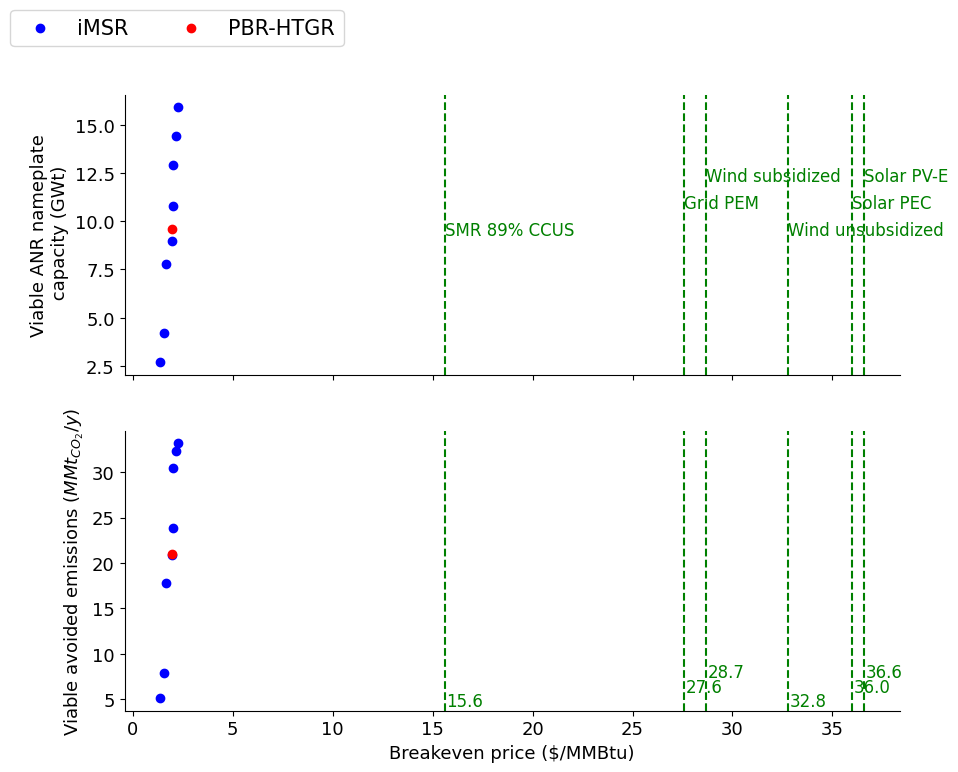

In [59]:
#Use latex font
#plt.rcParams['text.usetex'] = True
plt.rcParams['legend.fontsize'] = 15
plt.rcParams['font.size'] = 13

# Create subplots
fig, axs = plt.subplots(2, 1, sharex=True, figsize=(10, 8))

# Get unique ANR types and assign colors
anr_types = df['ANR type'].unique()

colors = ['blue', 'red', 'black']  # Adjust the colors according to the unique ANR types
# Initialize empty handles for legend
handles = []
# Plotting the data as scatter plots with different colors for each ANR type
labels = {'ANR Nameplate Capacity (GWt)': 'Viable ANR nameplate\n capacity (GWt)',
            'Viable avoided emissions (MMT-CO2/year)': r'Viable avoided emissions ($MMt_{CO_2}/y$)'}
for i, col in enumerate(['ANR Nameplate Capacity (GWt)', 'Viable avoided emissions (MMT-CO2/year)']):
    for anr_type, color in zip(anr_types, colors):
        subset = df[df['ANR type'] == anr_type]
        axs[i].scatter(subset['Breakeven price ($/MMBtu)'], subset[col], color=color, label=f'{anr_type}')
    axs[i].set_ylabel(labels[col])

    # Remove the top and right spines
    axs[i].spines['top'].set_visible(False)
    axs[i].spines['right'].set_visible(False)


    # Adding vertical lines
    import utils
    res_be = pd.read_csv('./results/res_be_steel.csv')
    res_be['Breakeven price ($/MMBtu)'] = res_be['Breakeven price ($/tcoal)']/utils.coal_heat_content
    res_be.sort_values(by='Breakeven price ($/MMBtu)', inplace=True)
    res_be['Breakeven price ($/MMBtu)'] = res_be.apply(lambda x:np.round(x['Breakeven price ($/MMBtu)'],1), axis=1)
    res_vert_lines = list(res_be['Breakeven price ($/MMBtu)'])
    coal_vertical_lines = [195]
    #for line in coal_vertical_lines:
     #   axs[i].axvline(x=line, linestyle='--', color='grey')
    for l,line in enumerate(res_vert_lines):
        axs[i].axvline(x=line, linestyle='--',color='green')


"""ng_labels = ['US coke\navg 2022']
for x, l in zip(coal_vertical_lines, ng_labels):
    axs[0].text(x-5, axs[0].get_ylim()[1]+0.2, l, fontsize=12, color='grey')
    axs[1].text(x, axs[i].get_ylim()[0]+2, str(x), color='grey', fontsize=12, va='top', ha='center')
"""
res_labels = res_be['RES']
count = 0
for x, label in zip(res_vert_lines, res_labels):
    axs[0].text(x, (axs[0].get_ylim()[1]+axs[0].get_ylim()[0])/2+1.4*np.mod(count,3), label, fontsize=12, color='green')
    axs[1].text(x+1, axs[1].get_ylim()[0]+2+1.6*np.mod(count,3), str(x), color='green', fontsize=12, va='top',ha='center')
    count+=1


# Setting the title and labels
plt.xlabel('Breakeven price ($/MMBtu)')


# Add a common legend for all subplots
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper left', ncol=len(anr_types))
#fig.tight_layout()
#plt.show()
plt.savefig(save_fig_path)